In [ ]:
!pip install pydicom python-gdcm pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg ultralytics

In [2]:
import pydicom
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageStat
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
from ultralytics import YOLO
import cv2
import albumentations as A
import torch

from timm.models import create_model
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image

In [3]:
data_path = '/data/datasets/rsna-breast-cancer-detection/'

In [4]:
# Load metadata
train_metadata = pd.read_csv(data_path + 'train.csv')
test_metadata = pd.read_csv(data_path + 'test.csv')

# Display the first few rows of the train metadata
print("Train Metadata:")
print(train_metadata.head())

# Display the first few rows of the test metadata
print("Test Metadata:")
print(test_metadata.head())

Train Metadata:
   site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True  
Test Metadata:
   site_id  patient_id    image_id laterality view  age 

In [76]:
# Function to load a DICOM image
def load_dicom_image(path):
    dicom_file = pydicom.dcmread(path)
    image_data = dicom_file.pixel_array
    window_center = dicom_file.WindowCenter if 'WindowCenter' in dicom_file else 2047
    window_width = dicom_file.WindowWidth if 'WindowWidth' in dicom_file else 4095
    invert = dicom_file.PhotometricInterpretation == "MONOCHROME1"
    if dicom_file.file_meta.TransferSyntaxUID.is_compressed:
        pass
    return image_data, window_center, window_width, invert

In [136]:
# Example: Load and display an image
# load 10 random number
rand_patients = np.random.randint(0, len(train_metadata), 30)
# sample image path
example_image_paths = [data_path + 'train_images/' + str(train_metadata.iloc[rand_patient]['patient_id']) + '/' + str(train_metadata.iloc[rand_patient]['image_id']) + '.dcm' for rand_patient in rand_patients]

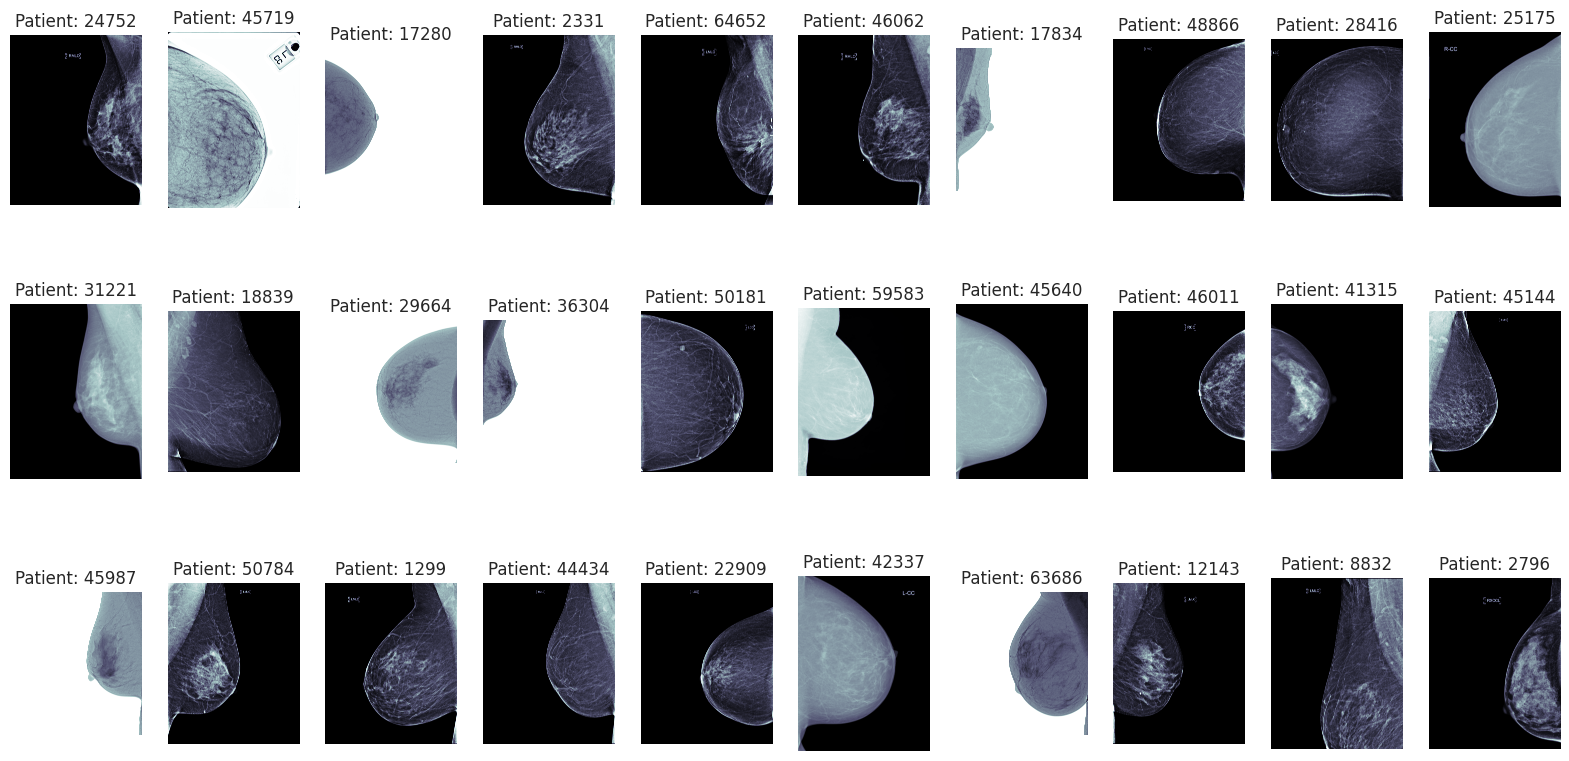

In [53]:
plt.figure(figsize=(20, 10))

for i, image in enumerate(example_image_paths):
    if os.path.exists(image):
        image, _, _, _ = load_dicom_image(image)
        plt.subplot(3, 10, i + 1)
        plt.imshow(image, cmap='bone')
        plt.axis('off')
        plt.title('Patient: ' + str(train_metadata.iloc[rand_patients[i]]['patient_id']))
    else:
        print('Dicom file not found!')
        
plt.show()

In [11]:
# Statistical analysis of metadata
print("\nAge Distribution in Train Set:")
print(train_metadata['age'].describe())

# Checking for class imbalance
print("\nCancer Class Distribution:")
print(train_metadata['cancer'].value_counts(normalize=True))


Age Distribution in Train Set:
count    54669.000000
mean        58.543928
std         10.050884
min         26.000000
25%         51.000000
50%         59.000000
75%         66.000000
max         89.000000
Name: age, dtype: float64

Cancer Class Distribution:
cancer
0    0.978832
1    0.021168
Name: proportion, dtype: float64


In [19]:
def image_statistics(image_path):
    try:
        dicom_image, _, _, _ = load_dicom_image(image_path)
        image = Image.fromarray(np.uint8(dicom_image)) 
        stat = ImageStat.Stat(image)
        return {"mean": stat.mean, "rms": stat.rms, "variance": stat.var}
    except Exception as e:
        print(f"Error in image_statistics: {e}")
        return None

# Example usage
stats = image_statistics(example_image_paths[0])
print(stats)

{'mean': [57.93568442418025], 'rms': [99.24548013606938], 'variance': [6493.12179774074]}


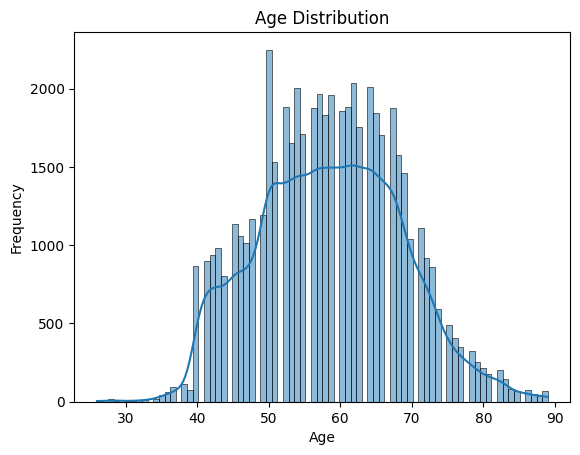

In [44]:
# Example: Plotting distribution of age
sns.histplot(train_metadata['age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Example: Correlation heatmap
correlation_matrix = train_metadata.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [21]:
# Crosstab between 'biopsy' and 'cancer'
pd.crosstab(train_metadata['biopsy'], train_metadata['cancer'])

cancer,0,1
biopsy,,
0,51737,0
1,1811,1158


In [37]:
# Create a new column for contrast
train_metadata['contrast'] = None

# Iterate over the DataFrame and apply texture analysis
for index, row in train_metadata.iterrows():
    image_path = f"{data_path}/train_images/{row['patient_id']}/{row['image_id']}.dcm"
    contrast = texture_analysis(image_path)
    train_metadata.at[index, 'contrast'] = contrast


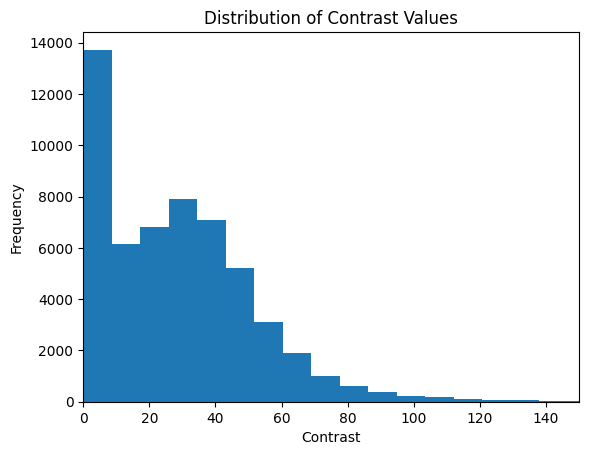

In [43]:
plt.hist(train_metadata['contrast'], bins=500)
plt.title('Distribution of Contrast Values')
plt.xlim(0, 150)
plt.xlabel('Contrast')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='site_id', ylabel='age'>

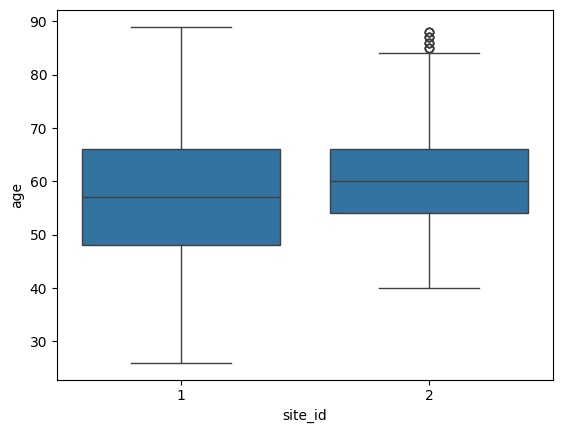

In [24]:
# Boxplot for a feature across different sites
sns.boxplot(x='site_id', y='age', data=train_metadata)

In [25]:
missing_data = train_metadata.isnull().sum()
print(missing_data)

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64


<Axes: >

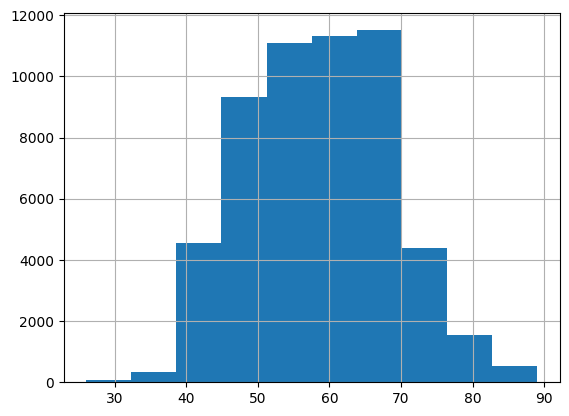

In [31]:
# Age distribution
train_metadata['age'].hist()

In [36]:
def texture_analysis(image_path):
    try:
        image, _, _, _ = load_dicom_image(image_path)
        # Ensure image is in the right format (2D and uint8)
        if image.ndim == 3:
            image = image[:, :, 0]  # Assuming grayscale, take the first channel
        image = (image / np.max(image) * 255).astype('uint8')  # Normalize and convert to uint8
        glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        return contrast
    except Exception as e:
        print(f"Error in texture_analysis: {e}")
        return None

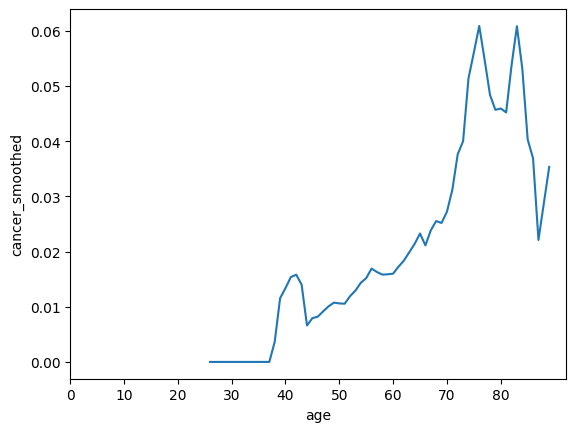

In [35]:
# Age vs. cancer rate, with age labels on x-axis only every 10 years
# Determine cancer rate for each age
age_cancer_rate = train_metadata.groupby('age')['cancer'].mean().reset_index()

# Interpolating missing ages (assuming age is a continuous variable)
age_cancer_rate['cancer_smoothed'] = age_cancer_rate['cancer'].rolling(window=5, min_periods=1).mean()

# Plot with smoothing
sns.lineplot(x='age', y='cancer_smoothed', data=age_cancer_rate)
plt.xticks(np.arange(0, 90, 10))
plt.show()


In [15]:
import cv2
# Crop image to breast region using bounding box and Otsu thresholding
def crop_coords(img):
    """
    Crop ROI from image.
    """
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return x, y, w, h


def truncation_normalization(img):
    """
    Clip and normalize pixels in the breast ROI.
    @img : numpy array image
    return: numpy array of the normalized image
    """
    Pmin = np.percentile(img[img!=0], 5)
    Pmax = np.percentile(img[img!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[img==0]=0
    return normalized


def clahe(img, clip):
    """
    Image enhancement.
    @img : numpy array image
    @clip : float, clip limit for CLAHE algorithm
    return: numpy array of the enhanced image
    """
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

In [7]:
roi_datapath = '/data/datasets/roi-dataset/rsna_annotations/yolo_ds/'

In [9]:
model = YOLO('yolov8n.pt')
roi_data = roi_datapath + 'data.yaml'
results = model.train(data=roi_data, epochs=25)

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/data/datasets/roi-dataset/rsna_annotations/yolo_ds/data.yaml, epochs=25, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mask

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /data/datasets/roi-dataset/rsna_annotations/yolo_ds/train/labels.cache... 425 images, 0 backgrounds, 0 corrupt: 100%|██████████| 425/425 [00:00<?, ?it/s]
val: Scanning /data/datasets/roi-dataset/rsna_annotations/yolo_ds/valid/labels.cache... 47 images, 0 backgrounds, 0 corrupt: 100%|██████████| 47/47 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train5
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25       2.5G     0.9551      1.928      1.438         22        640: 100%|██████████| 27/27 [00:01<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.36it/s]

                   all         47         47      0.989      0.787      0.977       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.36G      0.749      1.158      1.248         22        640: 100%|██████████| 27/27 [00:01<00:00, 19.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.31it/s]

                   all         47         47      0.951       0.83      0.931      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.36G     0.7655     0.9734      1.258         17        640: 100%|██████████| 27/27 [00:01<00:00, 21.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.40it/s]


                   all         47         47       0.77      0.851      0.926      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      2.36G     0.7811     0.9063      1.246         22        640: 100%|██████████| 27/27 [00:01<00:00, 22.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.22it/s]

                   all         47         47      0.993          1      0.995       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.36G     0.7916     0.8769      1.263         17        640: 100%|██████████| 27/27 [00:01<00:00, 23.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.31it/s]

                   all         47         47      0.498      0.957      0.575      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      2.36G     0.8141     0.8543       1.26         17        640: 100%|██████████| 27/27 [00:01<00:00, 20.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.01it/s]

                   all         47         47      0.822      0.872      0.895      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      2.35G     0.7083     0.6991      1.215         20        640: 100%|██████████| 27/27 [00:01<00:00, 23.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.25it/s]

                   all         47         47      0.977      0.906      0.971      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      2.36G     0.7028     0.6681      1.216         18        640: 100%|██████████| 27/27 [00:01<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.47it/s]

                   all         47         47      0.545      0.809      0.696       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      2.36G     0.6673     0.6158      1.182         19        640: 100%|██████████| 27/27 [00:01<00:00, 22.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.33it/s]

                   all         47         47      0.805      0.915      0.907       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      2.36G     0.6712     0.5919      1.161         27        640: 100%|██████████| 27/27 [00:01<00:00, 22.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.50it/s]

                   all         47         47      0.998          1      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      2.35G     0.6408     0.5666      1.159         24        640: 100%|██████████| 27/27 [00:01<00:00, 21.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.36it/s]

                   all         47         47      0.998          1      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      2.36G      0.657     0.5658      1.158         20        640: 100%|██████████| 27/27 [00:01<00:00, 22.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.89it/s]

                   all         47         47      0.998          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      2.36G     0.5844     0.5037      1.128         19        640: 100%|██████████| 27/27 [00:01<00:00, 22.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.21it/s]

                   all         47         47      0.999          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      2.36G      0.603      0.506      1.129         21        640: 100%|██████████| 27/27 [00:01<00:00, 21.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.39it/s]

                   all         47         47      0.866      0.962      0.982      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      2.35G     0.6118     0.5013      1.143         19        640: 100%|██████████| 27/27 [00:01<00:00, 19.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.51it/s]

                   all         47         47      0.994          1      0.995      0.911


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25       2.5G     0.4786     0.4574      1.112          9        640: 100%|██████████| 27/27 [00:01<00:00, 16.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.02it/s]

                   all         47         47      0.999          1      0.995      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      2.36G     0.4618      0.407      1.115          9        640: 100%|██████████| 27/27 [00:01<00:00, 21.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.23it/s]

                   all         47         47      0.999          1      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      2.36G     0.4489     0.3797      1.084          9        640: 100%|██████████| 27/27 [00:01<00:00, 21.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.24it/s]

                   all         47         47      0.999          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      2.35G     0.4574     0.3754      1.096          9        640: 100%|██████████| 27/27 [00:01<00:00, 21.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.83it/s]

                   all         47         47      0.998          1      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      2.36G     0.4196     0.3501      1.095          9        640: 100%|██████████| 27/27 [00:01<00:00, 21.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.45it/s]

                   all         47         47      0.999          1      0.995      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      2.36G     0.4073     0.3387       1.04          9        640: 100%|██████████| 27/27 [00:01<00:00, 22.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.88it/s]

                   all         47         47      0.999          1      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      2.36G     0.4094     0.3248      1.074          9        640: 100%|██████████| 27/27 [00:01<00:00, 21.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.41it/s]

                   all         47         47      0.999          1      0.995      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      2.35G     0.3715     0.3033      1.033          9        640: 100%|██████████| 27/27 [00:01<00:00, 21.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.39it/s]

                   all         47         47      0.999          1      0.995      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      2.36G     0.3455     0.2894      1.009          9        640: 100%|██████████| 27/27 [00:01<00:00, 20.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.55it/s]

                   all         47         47      0.999          1      0.995      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      2.36G     0.3605      0.288      1.026          9        640: 100%|██████████| 27/27 [00:01<00:00, 21.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.45it/s]

                   all         47         47      0.999          1      0.995       0.95



25 epochs completed in 0.014 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 48647MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.60it/s]


                   all         47         47      0.999          1      0.995      0.951
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train5


lr/pg0,▃▅▇███▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
lr/pg1,▃▅▇███▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
lr/pg2,▃▅▇███▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),█▇▇█▁▆█▃▇████████████████
metrics/mAP50-95(B),▅▅▆▇▁▅▅▃▆▇▇▇▇▇▇██▇███████
metrics/precision(B),█▇▅█▁▆█▂▅████▆███████████
metrics/recall(B),▁▂▃█▇▄▅▂▅████▇███████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▆▆▆▆▅▅▅▅▄▅▄▄▄▃▂▂▂▂▂▂▁▁▁


In [6]:
# load model
yolo_model = YOLO('runs/detect/train5/weights/best.pt')

In [66]:
def invert_image_if_white_background(image_to_invert):
    """
    Invert the image.

    :param image_to_invert: A DICOM image as a NumPy array.
    :return: Inverted image.
    """      
    return image_to_invert.max() - image_to_invert

In [8]:
def resize_and_pad_image_isotropically(image, target_size):
    """
    Resize image to the target size, conserving aspect ratio and adding padding if needed.
    :param image: an image to resize
    :param target_size: target size of the image (width, height)
    :return: resized and padded image
    """
    h, w = image.shape[:2]
    # check for zero sized images
    if h == 0 or w == 0:
        print(f"Can't resize image with size 0: {image.shape}")
        raise ValueError(f"Can't resize image with size 0: {image.shape}")
    sh, sw = target_size

    # Interpolation method
    interp = cv2.INTER_AREA if h > sh or w > sw else cv2.INTER_CUBIC

    # Aspect ratio of image
    aspect = w / h

    # Compute new dimensions and scaling factor
    scale_w = sw / w
    scale_h = sh / h
    scale = min(scale_w, scale_h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Calculate padding
    pad_left = (sw - new_w) // 2
    pad_right = sw - new_w - pad_left
    pad_top = (sh - new_h) // 2
    pad_bot = sh - new_h - pad_top

    # Resize the image
    resized_img = cv2.resize(image, (new_w, new_h), interpolation=interp)

    # Add padding
    resized_img = cv2.copyMakeBorder(resized_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return resized_img

In [9]:
def convert_image_float32_and_normalize(original_image):
    """
    Convert the image to float32 and normalize to [0, 1].
    :param original_image: The image as a NumPy array.
    :return: A normalized image as a NumPy array.
    """
    resized_image = original_image.astype(np.float32) / np.max(original_image)  # Normalize to [0, 1]
    return resized_image

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert numpy array to PyTorch Tensor
    # Add any other necessary transformations here
])

In [67]:
def load_and_preprocess_images(image_paths):
    """
    Load DICOM images and apply initial preprocessing.
    """
    images = []
    window_centers = []
    window_widths = []
    inverts = []
    for img_path in image_paths:
        try:
            img, window_center, window_width, invert = load_dicom_image(img_path)
            images.append(img)
            window_centers.append(window_center)
            window_widths.append(window_width)
            inverts.append(invert)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            images.append(None)
            window_centers.append(None)
            window_widths.append(None)
            inverts.append(None)
            
    return images, window_centers, window_widths, inverts


def resize_image_for_yolo(image, target_size=(640, 640)):
    """
    Resize image maintaining aspect ratio and padding for YOLO model.
    """
    # Resize and pad the image as required by YOLO
    resized_img = resize_and_pad_image_isotropically(image, target_size)
    return resized_img

In [68]:
def preprocess_for_yolo(images, inverts):
    """
    Preprocess images for YOLO model input.
    """
    processed_images = []
    for img, invert in zip(images, inverts):
        if img is not None:
            try:
                # Invert image if it has a white background
                img = invert_image_if_white_background(img) if invert else img
                # Resize image to the input size expected by YOLO (e.g., 640x640)
                resized_img = resize_image_for_yolo(img, (640, 640))

                # Convert image to float32 and normalize
                normalized_img = convert_image_float32_and_normalize(resized_img)

                # Convert image to PyTorch tensor and add batch dimension
                tensor_img = transform(normalized_img).unsqueeze(0)

                processed_images.append(tensor_img)
            except Exception as e:
                print(f"Error preprocessing for YOLO: {e}")
                processed_images.append(None)
        else:
            processed_images.append(None)

    # Concatenate all tensor images into a single batch
    batched_tensor = torch.cat([img for img in processed_images if img is not None], dim=0)
    # Convert to rgb
    batched_tensor_rgb = batched_tensor.repeat(1, 3, 1, 1)
    return batched_tensor_rgb

In [78]:
def calculate_resized_dimensions(original_size, target_size=(640, 640)):
    """
    Calculate the resized dimensions of an image, for use in transforming bbox to original image size.
    :param original_size: The starting size of the image as a tuple (width, height).
    :param target_size: The target size of the image as a tuple (width, height).
    :return: 
    """
    original_width, original_height = original_size
    target_width, target_height = target_size

    # Calculate aspect ratio
    aspect_ratio = original_width / original_height

    # Determine resized dimensions before padding
    if aspect_ratio > 1:  # Landscape orientation
        resized_width = target_width
        resized_height = int(resized_width / aspect_ratio)
    else:  # Portrait orientation or square
        resized_height = target_height
        resized_width = int(resized_height * aspect_ratio)

    return resized_width, resized_height


def convert_bbox_to_original_with_padding(bbox, original_size, padded_size=(640, 640)):
    """
    Convert bounding box coordinates from a resized and padded image to the original image.

    :param bbox: Tuple (xmin, ymin, xmax, ymax) on the resized and padded image.
    :param original_size: Tuple (original_width, original_height) of the image.
    :param padded_size: Final size of the image after padding.
    :return: Adjusted bounding box coordinates as a tuple.
    """
    resized_width, resized_height = calculate_resized_dimensions(original_size, padded_size)
    scale_w = original_size[0] / resized_width
    scale_h = original_size[1] / resized_height

    # Determine padding added during resizing
    pad_w = (padded_size[0] - resized_width) / 2
    pad_h = (padded_size[1] - resized_height) / 2

    # Adjust bounding box coordinates
    xmin, ymin, xmax, ymax = bbox.flatten()
    xmin_original = max((xmin - pad_w) * scale_w, 0)  # Ensure non-negative
    ymin_original = max((ymin - pad_h) * scale_h, 0)  # Ensure non-negative
    xmax_original = min((xmax - pad_w) * scale_w, original_size[0])  # Ensure within original width
    ymax_original = min((ymax - pad_h) * scale_h, original_size[1])  # Ensure within original height

    return xmin_original, ymin_original, xmax_original, ymax_original


def crop_image(uncropped_image, bbox):
    """
    Crop an image to the bounding box coordinates.

    :param uncropped_image: The image as a NumPy array.
    :param bbox: Tuple (xmin, ymin, xmax, ymax) of the bounding box coordinates.
    :return: Cropped image as a NumPy array.
    """
    xmin, ymin, xmax, ymax = bbox
    # if crop would be empty, return original image
    if xmin == xmax or ymin == ymax:
        return uncropped_image
    else:
        return uncropped_image[int(ymin):int(ymax), int(xmin):int(xmax)]


def crop_images_with_yolo(raw_images, yolo_model, inverts):
    """
    Crop images using the YOLO model.
    """
    preprocessed_images = preprocess_for_yolo(raw_images, inverts)
    yolo_results = yolo_model(preprocessed_images, verbose=False)
    cropped_images = []
    for i, result in enumerate(yolo_results):
        if raw_images[i] is not None:
            try:
                bbox = convert_bbox_to_original_with_padding(result.boxes[0].xyxy.cpu().numpy(), (raw_images[i].shape[1], raw_images[i].shape[0]))
                cropped_img = crop_image(raw_images[i], bbox)
                cropped_images.append(cropped_img)
            except Exception as e:
                print(f"Error cropping image: {e}")
                cropped_images.append(None)
        else:
            cropped_images.append(None)
    return cropped_images


In [79]:
def apply_window_single(image_to_window, win_center, win_width):
    """
    Apply windowing to a grayscale image.

    :param image_to_window: The image as a NumPy array.
    :param win_center: The window center.
    :param win_width: The window width.
    :return: The windowed image as a NumPy array.
    """
    # Check that image is numpy array
    assert isinstance(image_to_window, np.ndarray)
    # Handle MultiValue objects
    if isinstance(win_width, pydicom.multival.MultiValue):
        # Choose the first value
        win_width = float(win_width[0])

    if isinstance(win_center, pydicom.multival.MultiValue):
        win_center = float(win_center[0])

    window_min = win_center - (win_width / 2)
    window_max = win_center + (win_width / 2)

    return np.clip(image_to_window, window_min, window_max)


def apply_windowing(images, window_centers_array, window_widths_array):
    """
    Apply windowing to a batch of images.
    """
    images_to_return = []
    for img, window_cnt, window_wid in zip(images, window_centers_array, window_widths_array):
        if img is not None:
            try:
                windowed_img = apply_window_single(img, window_cnt, window_wid)
                images_to_return.append(windowed_img)
            except Exception as e:
                print(f"Error applying windowing: {e}")
                images_to_return.append(None)
        else:
            images_to_return.append(None)
    return images_to_return


def convert_to_rgb_and_normalize(images):
    """
    Convert images to RGB and normalize.
    """
    final_images = []
    for img in images:
        if img is not None and np.max(img) > 0:
            try:
                normalized_img = (img - np.min(img)) / (np.max(img) - np.min(img))
                scaled_img = np.uint8(normalized_img * 255)
                # Convert to RGB and scale to [0, 255]
                rgb_img = np.stack((scaled_img, scaled_img, scaled_img), axis=-1)
                final_images.append(rgb_img)
            except Exception as e:
                print(f"Error converting/normalizing image: {e}")
                final_images.append(None)
        else:
            final_images.append(None)
    return final_images

In [89]:
def preprocess_dicom_images(image_paths, YOLO_model):
    """
    Preprocess DICOM images for training.
    """
    images, window_centers, window_widths, inverts = load_and_preprocess_images(image_paths)
    cropped_images = crop_images_with_yolo(images, YOLO_model, inverts)
    windowed_images = apply_windowing(cropped_images, window_centers, window_widths)
    rgb_images = convert_to_rgb_and_normalize(windowed_images)
    rgb_images = [invert_image_if_white_background(img) if invert else img for img, invert in zip(rgb_images, inverts)]
    final_images = [resize_and_pad_image_isotropically(img, target_size=(2048, 1024)) for img in rgb_images]
    
    return final_images

In [90]:
from tqdm import tqdm
def save_image(image, save_path):
    """
    Save a NumPy array as an image.
    :param image: The image as a NumPy array.
    :param save_path: The path to save the image.
    :return: None
    """
    # Convert to PIL Image
    image = Image.fromarray(image)
    # Save to disk
    image.save(save_path)

def batch_preprocess_and_save(metadata_df, batch_size, YOLO_model, save_dir):
    """
    Preprocess DICOM images for training and save them to disk.
    :param image_paths: Image paths to preprocess.
    :param batch_size: Batch size.
    :param YOLO_model: Pretrained YOLO model.
    :param save_dir: Path to save the preprocessed images.
    :return: Modified metadata DataFrame.
    """
    image_paths = metadata_df['image_path'].values
    num_batches = len(image_paths) // batch_size + int(len(image_paths) % batch_size != 0)
    metadata_df = metadata_df.copy()
    
    for i in tqdm(range(num_batches), desc='Preprocessing images'):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        batch_paths = image_paths[start_idx:end_idx]
        
        try:
            batch_images = preprocess_dicom_images(batch_paths, YOLO_model)
        
            for j, img in enumerate(batch_images):
                save_path = os.path.join(save_dir, f"preprocessed_{start_idx + j}.png")
                metadata_df.at[start_idx + j, 'preprocessed_image_path'] = save_path
                save_image(img, save_path)
        except Exception as e:
            print(f"Error in batch_preprocess_and_save: {e}")
            continue

    return metadata_df

In [91]:
train_metadata['image_path'] = data_path + 'train_images/' + train_metadata['patient_id'].astype(str) + '/' + train_metadata['image_id'].astype(str) + '.dcm'

In [92]:
len(train_metadata[train_metadata['cancer'] == 1])
df_cancer = train_metadata[train_metadata['cancer'] == 1]
df_no_cancer = train_metadata[train_metadata['cancer'] == 0]
df_no_cancer_sampled = df_no_cancer.sample(n=(2 * len(df_cancer)))
balanced_data = pd.concat([df_cancer, df_no_cancer_sampled])
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)

In [93]:
save_dir = '/data/datasets/rsna-breast-cancer-detection/preprocessed_images/'
updated_meta_df = batch_preprocess_and_save(balanced_data, 10, yolo_model, save_dir)

Preprocessing images:  82%|████████▏ | 287/348 [23:08<04:43,  4.66s/it]

Error cropping image: index 0 is out of bounds for dimension 0 with size 0


Preprocessing images:  83%|████████▎ | 288/348 [23:10<04:00,  4.01s/it]

Error in batch_preprocess_and_save: 'NoneType' object has no attribute 'shape'


Preprocessing images: 100%|██████████| 348/348 [27:53<00:00,  4.81s/it]


In [94]:
updated_meta_df_cleaned = updated_meta_df.dropna(subset=['preprocessed_image_path'])
updated_meta_df_cleaned.to_csv(data_path + 'balanced_subset.csv')

In [95]:
updated_meta_df_cleaned = pd.read_csv(data_path + 'balanced_subset.csv')

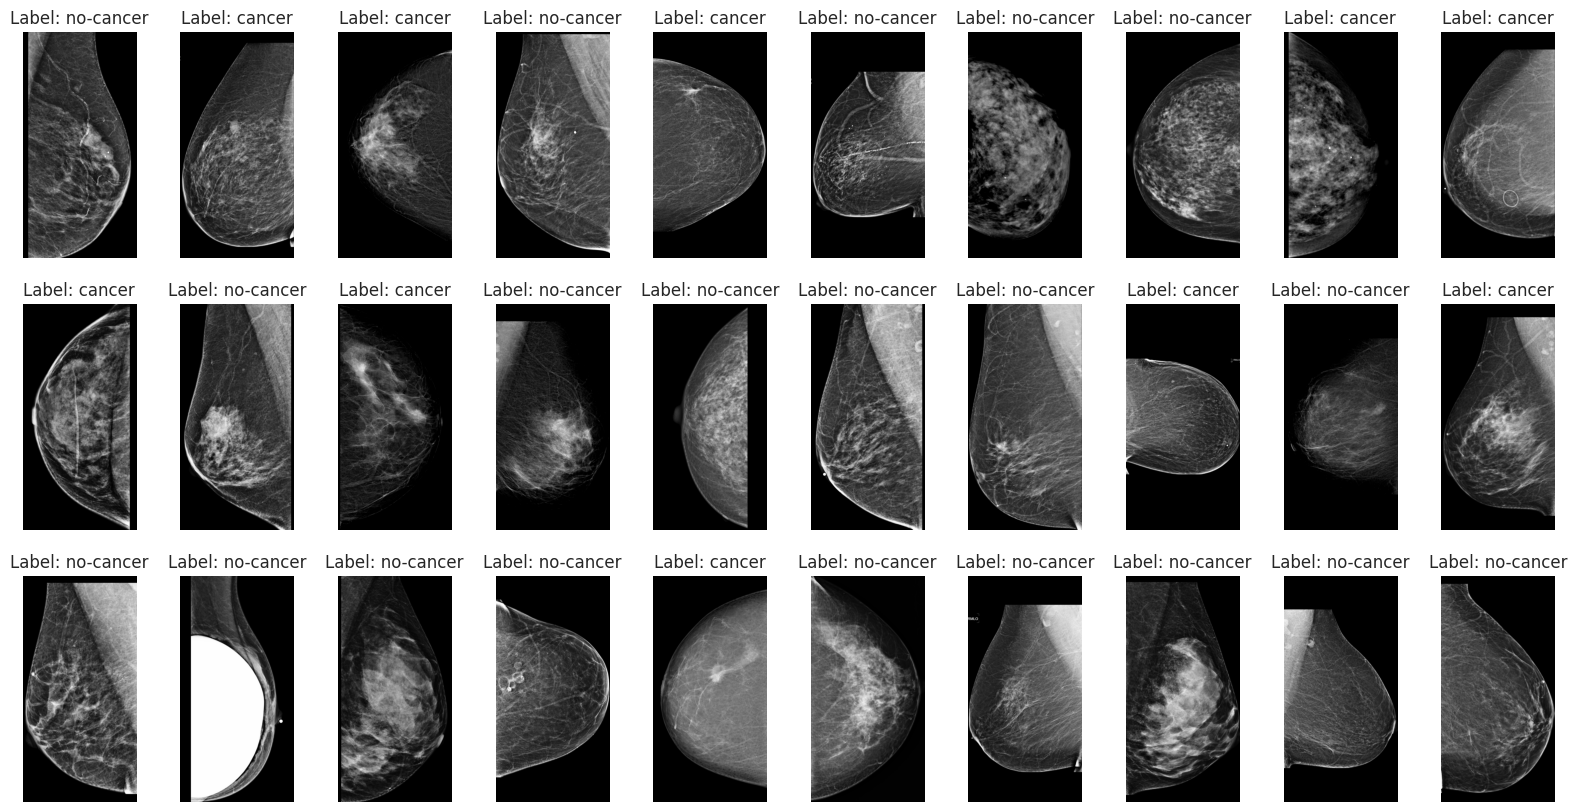

In [96]:
# Plot a few random preprocessed images
rand_patients = np.random.randint(0, len(updated_meta_df_cleaned), 30)
example_image_paths = [updated_meta_df_cleaned.iloc[rand_patient]['preprocessed_image_path'] for rand_patient in rand_patients]

plt.figure(figsize=(20, 10))
labels = ['no-cancer', 'cancer']
for i, image in enumerate(example_image_paths):
    if os.path.exists(image):
        image = Image.open(image)
        plt.subplot(3, 10, i + 1)
        plt.imshow(image, cmap='bone')
        plt.axis('off')
        plt.title('Label: ' + labels[updated_meta_df_cleaned.iloc[rand_patients[i]]['cancer']])
    else:
        print('Image not found!')
        
plt.show()

In [97]:
def create_convnext_model(model_name, num_classes, in_chans=3, global_pool='avg'):
    """
    Create a ConvNext model.
    :param model_name: name of the model
    :param num_classes: number of classes
    :param in_chans: number of input channels
    :param global_pool: type of global pooling
    :return: ConvNext model
    """
    convnext_model = create_model(
        model_name,
        pretrained=True,
        num_classes=num_classes,
        in_chans=in_chans,
        global_pool=global_pool,
    )
    return convnext_model

In [98]:
model_info = {
    'model_name': 'convnext_small.fb_in22k_ft_in1k_384',
    'num_classes': 1,
    'in_chans': 3,
    'global_pool': 'max',
}

In [99]:
# Create a Dataset object, with the image paths, plus the target from the new metadata df
class ImageDataset(Dataset):
    def __init__(self, metadata_df, transform=None):
        self.image_paths = metadata_df['preprocessed_image_path'].values
        self.targets = metadata_df['cancer'].values
        self.transform = transform if transform is not None else transforms.ToTensor()
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # load the image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        # get the target
        target = self.targets[idx]
        # apply the transform
        if self.transform:
            image = self.transform(image)
        return image, target

In [100]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(updated_meta_df_cleaned, test_size=0.2, random_state=42)

In [101]:
# Create random split of data into train and val
train_dataset = ImageDataset(train_df)
# Create a Dataset object using small subset of the data
val_dataset = ImageDataset(val_df)

In [102]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [103]:
def calculate_accuracy(outputs, targets, threshold=0.5):
    """
    Calculate the accuracy of the model's predictions.
    :param outputs: Model outputs.
    :param targets: True labels.
    :param threshold: Threshold for the predictions.
    :return: Accuracy.
    """
    # Apply sigmoid to the outputs to get predictions
    predictions = torch.sigmoid(outputs) > threshold
    # Calculate accuracy
    correct = (predictions == targets.unsqueeze(1)).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

In [118]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, scheduler, device, epochs=1, grad_accum_steps = 1):
    """
    Train and evaluate the model for n epochs.
    :param model: Model to train and evaluate.
    :param train_loader: Training data loader.
    :param val_loader: Validation data loader.
    :param optimizer: Optimizer.
    :param criterion: Loss function.
    :param device: Device to use for training.
    :param epochs: Number of epochs to train.
    :return: Tuple of average training loss and average validation loss.
    """
    avg_train_loss = 0
    avg_val_loss = 0
    
    classnames = ['no-cancer', 'cancer']
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        accum_iter = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.unsqueeze(1).float()) / grad_accum_steps
            loss.backward()
            
            if (accum_iter + 1) % grad_accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
                
            accum_iter += 1
            train_loss += loss.item()
            
            train_loss += loss.item() * grad_accum_steps
            print(f'\rEpoch: {epoch + 1}, Batch {batch_idx + 1}/{len(train_loader)} - Loss: {loss.item():.6f}', end='')
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Evaluation loop
        model.eval()
        val_loss = 0
        total_accuracy = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target.unsqueeze(1).float())
                val_loss += loss.item()
                val_accuracy = calculate_accuracy(output, target)
                total_accuracy += val_accuracy.item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = total_accuracy / len(val_loader)

        print(f'\nEpoch: {epoch + 1}, Train Loss: {avg_train_loss:.6f}, Val accuracy {avg_val_accuracy:.2f}%, Validation Loss: {avg_val_loss:.6f}')
        
        # Step the scheduler
        scheduler.step(epoch)

    return avg_train_loss, avg_val_loss

In [119]:
import torch.nn as nn

conv_model = create_convnext_model(**model_info)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_model.to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    conv_model = nn.DataParallel(conv_model)

Using 2 GPUs!


In [120]:
from timm.loss import BinaryCrossEntropy
from timm.optim import create_optimizer_v2
from timm.scheduler import create_scheduler_v2
optimizer = create_optimizer_v2(conv_model, opt='sgd', lr=3e-4, weight_decay=1e-5, momentum=0.9)
criterion = BinaryCrossEntropy(smoothing=0.1, target_threshold=0.5)
scheduler, num_epochs = create_scheduler_v2(optimizer, sched='cosine', num_epochs=100, decay_epochs=10, cooldown_epochs=1, warmup_epochs=4, min_lr=5e-5)

In [ ]:
train_loss, val_loss = train_and_evaluate(conv_model, train_dataloader, val_dataloader, optimizer, criterion, scheduler, device, epochs=num_epochs, grad_accum_steps=4)

Epoch: 1, Batch 56/693 - Loss: 0.160580

In [90]:
import gc
gc.collect()
torch.cuda.empty_cache()